In [1]:
import jax.numpy as np
from jax import jit
import numpy.random as npr
import matplotlib.pyplot as plt
from ipywidgets import interact, FloatSlider

%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

# Linear Regression

Linear regression is foundational to deep learning. It should be a model that everybody has been exposed to before. However, it is important for us to go through this with a view to how we connect linear regression to the neural diagrams that are shown.

## Discussion

- In our machine learning toolkit, where do we use linear regression? 
- What are its advantages? 
- What are its disadvantages?

## Equation Form

Linear regression, as a model, is expressed as follows:

$$y = wx + b$$

Here:

- The **model** is the equation, $y = wx + b$.
- $y$ is the output data.
- $x$ is our input data.
- $w$ is a slope parameter.
- $b$ is our intercept parameter.
- Implicit in the model is the fact that we have transformed $y$ by another function, the "identity" function, $f(x) = x$.

In this model, $y$ and $x$ are, in a sense, "fixed", because this is the data that we have obtained. On the other hand, $w$ and $b$ are the parameters of interest, and *we are interested in **learning** the parameter values for $w$ and $b$ that let our model best explain the data*.

I will reveal the punchline early:

> The **learning** in deep learning is about figuring out parameter values for a given model.

## Make Simulated Data

To explore this idea in a bit more depth as applied to a linear regression model, let us start by making some simulated data with a bit of injected noise.

You can specify a true $w$ and a true $b$ as you wish, or you can just follow along.

### Exercise

In [ ]:
x = np.linspace(-5, 5, 1000)
w_true = 3.14  # exercise: specify ground truth w.
b_true = 2.72  # exercise: specify ground truth b.

def noise(n):
    return npr.normal(size=(n))

# exercise: write the linear equation down.
y = w_true * x + b_true + noise(len(x))

# Plot ground truth data
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')

### Exercise

Now, let's plot what would be a very bad estimate of $w$ and $b$. 

In [ ]:
# Plot a very bad estimate
w = 6.28  # exercise: fill in a bad value for w
b = -42   # exercise: fill in a bad value for b
y_est = w * x + b  # exercise: fill in the equation.
plt.plot(x, y_est, color='red', label='bad model')
plt.scatter(x, y, label='data')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

## Loss Function

How bad is our model? We can quantify this by looking at a metric called the "mean squared error". The mean squared error is defined as "the average of the sum of squared errors".

We calculate it this way. Firstly, we calculate the **residual** $d$, which is the difference between the **model prediction** $\hat{y_i}$ for a given sample $i$ and its true value $y_i$:

$$
d_i = \hat{y_i} - y_i
$$

Then we take the sum of square of residuals $r$ over all samples:

$$
r = \sum_i^n{d^2_i}
$$

Finally, we divide it by the number of sample $n$:

$$
\text{MSE} = 
\frac{r}{n} = 
\frac{
    \sum_i^n{
        d^2_i
    }
}{n} = 
\frac{
    \sum_i^n{
        (
            {
                \hat{y_i} - y_i
            }
        )^2
    }
}{n}
$$

"Mean squared error" is but one of many **loss functions** that are available in deep learning frameworks. It is commonly used for regression tasks.

Loss functions are designed to quantify how bad our model is in predicting the data.

### Exercise

Let's implement the mean squared error function.

In [ ]:
# Exercise: implement mean squared error function in NumPy code.
# It should take in y_true and y_pred as arguments,
# and return a scalar.
def mse(y_true: np.ndarray, y_pred: np.ndarray) -> np.ndarray:
    # Your code here
    # d = y_true - y_pred
    # sq_d = np.power(d, 2)
    # loss = np.mean(sq_d)
    # return loss

    # A more compact way:
    return np.mean(np.power(y_true - y_pred, 2))

# Calculate the mean squared error between 
mse(y, y_est)

### Activity: Optimize model by hand.

Now, we're going to optimize this model by hand. Use the sliders provided to adjust the model.

In [ ]:
@interact(
    w=FloatSlider(min=-10, max=10, step=0.1), 
    b=FloatSlider(min=0, max=30, step=0.1)
)
def optimize_plot(w, b):
    y_est = x * w + b
    plt.scatter(x, y, alpha=0.3, label='data')
    plt.plot(x, y_est, color='red', label='model')
    plt.xlabel('x')
    plt.ylabel('y')
    plt.legend()
    plt.title(f'MSE: {mse(y, y_est):.02f}')

### Discussion

As you were optimizing the model, what did you notice about the MSE? score?

# Detour: Gradient-Based Optimization

Implicit in what you were doing was something we formally call "gradient-based optimization". This is a very important point to understand. If you get this for a linear model, you will understand how this works for more complex models. Hence, we are going to go into a small crash-course detour on what gradient-based optimization is.

## Derivatives

At the risk of ticking off mathematicians for a sloppy definition, for this workshop's purposes, a useful way of defining the derivative is:

> How much our output changes as we take a small step on the inputs, taken in the limit of going to very small steps.

If we have a function:

$$f(w) = w^2 + 3w - 5$$

What is the derivative of $f(x)$ with respect to $w$? From first-year undergraduate calculus, we should be able to calculate this:

$$f'(w) = 2w + 3$$

(We will use the apostrophe marks to indicate derivatives. 1 apostrophe mark means first derivative, 2nd apostrophe mark means 2nd derivative.)

## Minimizing $f(w)$ Analytically

What is the value of $w$ that minimizes $f(w)$? Again, from undergraduate calculus, we know that at a minima of a function (whether it is a global or local), the first derivative will be equal to zero, i.e. $f'(w) = 0$. By taking advantage of this property, we can analytically solve for the value of $w$ at the minima.

$$2w + 3 = 0$$

Hence, 

$$w = -\frac{3}{2} = -1.5$$

To check whether the value of $w$ at the place where $f'(w) = 0$ is a minima or maxima, we can use another piece of knowledge from 1st year undergraduate calculus: The sign of the second derivative will tell us whether this is a minima or maxima.

- If the second derivative is positive regardless of the value of $w$, then the point is a minima. (Smiley faces are positive!)
- If the second derivative is negative regardless of the value of $w$, then the point is a maxima. (Frowning faces are negative!)

Hence, 

$$f''(w) = 2$$

We can see that $f''(w) > 0$ for all $w$, hence the stationary point we find is going to be a local minima.

## Minimizing $f(w)$ Computationally

An alternative way of looking at this is to take advantage of $f'(w)$, the gradient, evaluated at a particular $w$. A known property of the gradient is that if you take steps in the negative direction of the gradient, you will eventually reach a function's minima. If you take small steps in the positive direction of the gradient, you will reach a function's maxima (if it exists).

### Exercise

Let's implement this using the function $f(w)$, done using NumPy.

In [ ]:
# Exercise: Write f(w) as a function.
def f(w):
    """
    Note: We don't use this function in this
    cell.
    """
    return w**2 + 3*w -5


# Exercise: Write df(w) as a function. 
def df(w):
    """
    Derivative of f with respect to w.
    """
    return 2*w + 3

# Exercise: Pick a number to start w at.
w = np.pi  # start with a float

# Now, adjust the value of w 1000 times, taking small steps in the negative direction of the gradient.
history = []
for i in range(1000):
    history.append(w)
    w = w - df(w) * 0.01  # 0.01 is an arbitrary number chosen, which is the step size taken
    
print(w)

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history)

Congratulations, you have just implemented **gradient descent** (SGD)!

Gradient descent is an **optimization routine**: a way of programming a computer to do optimization for you so that you don't have to do it by hand.

## Minimizing $f(w)$ with `jax`

`jax` is a Python package for automatically computing gradients; it is known as an "automatic differentiation" system. This way, we do not have to specify the gradient function by hand-calculating it; rather, `jax` will know how to automatically take the derivative of a Python function w.r.t. the first argument. With `jax`, our example above is modified in only a slightly different way.

In [5]:
from jax import grad
from tqdm import tqdm_notebook as tqdmn

def f(w):
    return w**2 + 3 * w - 5

# This is what changes: we use the `grad` function to automatically return a gradient function.
df = grad(f)

# Exercise: Pick a number to start w at.
w = np.pi

# Now, adjust the value of w 1000 times, taking small steps in the negative direction of the gradient.
for i in tqdmn(range(1000)):
    w = w - df(w) * 0.01
    
print(w)

/Users/ben/opt/miniconda3/envs/dl-workshop/lib/python3.7/site-packages/ipykernel_launcher.py:14: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  


/Users/ben/opt/miniconda3/envs/dl-workshop/lib/python3.7/site-packages/jax/lib/xla_bridge.py:123: UserWarning: No GPU/TPU found, falling back to CPU.
  warnings.warn('No GPU/TPU found, falling back to CPU.')



-1.4999971


# Back to Optimizing Linear Regression

## What are we optimizing?

In linear regression, we are minimizing (i.e. optimizing) the loss function w.r.t. the linear regression parameters.

**Keep in mind:** The loss function is the parallel to the $f(w)$ polynomial function that we were playing around with above.

## Ingredients for "Optimizing" a Model

At this point, we have learned what the ingredients are for optimizing a model:

1. A model, which is a function that maps inputs $x$ to outputs $y$, and its parameters of the model. In our linear regression case, this is $w$ and $b$; usually, in the literature, we call this a **parameter set** $\theta$.
2. Loss function, which tells us how bad our predictions are.
3. Optimization routine, which tells the computer how to adjust the parameter values to minimize the loss function.

**Keep note:** Because we are optimizing the loss w.r.t. two parameters, finding the $w$ and $b$ coordinates that minimize the loss is like finding the minima of a bowl.

The latter point, which is "how to adjust the parameter values to minimize the loss function", is the key point to understand here. 

## Code-Along Exercise

We are going to write code to tie this all together. In order help you follow along, I will type this in full, but you will only have to fill-in-the-blanks. 

In [ ]:
# Exercise: Define the model
def model(p: dict, x: np.ndarray) -> np.ndarray:
    """
    :param p: dictionary of values.
    :param x: input data
    """
    return p["w"] * x + p["b"]

# Initialize values of w and b. 
# We will store the parameter values in a dictionary.
# The dict keys are the name of the parameter,
# and the dict values are the parameter values.
params = dict()
params['w'] = npr.normal()  # draw one value from standard normal
params['b'] = npr.normal()  # FITB


# Differentiable loss function w.r.t. 1st argument
def mseloss(params, x, y):
    """
    :param params: Dictionary of parameters
    :param x: input data
    :param y: ground truth outputs
    """
    y_est = model(params, x)
    return mse(y, y_est)

dmseloss = grad(mseloss)  # derivative of loss function

# Optimization routine
losses = []
for i in tqdmn(range(3000)):
    # Evaluate the gradient at the given params values.
    grad_p = dmseloss(params, x, y)
    
    # Update the gradient values for each parameter.
    for name, param_val in params.items():
        params[name] = params[name] - grad_p[name] * 0.001
        
    # Keep track of losses.
    losses.append(mseloss(params, x, y))

Now, let's plot the loss score over time. It should be going downwards.

In [ ]:
plt.plot(losses)
plt.xlabel('iteration')
plt.ylabel('mse')
plt.show()

In [ ]:
from pprint import pprint

pprint(params)

In [ ]:
y_est = model(params, x)
plt.scatter(y, y_est)

# Recap: Ingredients

1. Model specification ("equations", e.g. $y = wx + b$) and the parameters of the model to be optimized ($w$ and $b$, or more generally, $\theta$).
2. Loss function: tells us how wrong our model parameters are w.r.t. the data ($MSE$)
3. Opitmization routine (for-loop)

# Linear Regression, Extended

Thus far, we have shown linear regression using only one-dimensional inputs (i.e. one column of data). Linear regression has been extended to higher dimensional inputs, i.e. two or more columns of data.

## In Pictures

Linear regression can be expressed pictorially, not just in equation form. Here are two ways of visualizing linear regression.

### Matrix Form

Linear regression in one dimension looks like this:

![](../figures/linreg-scalar.png)

Linear regression in higher dimensions looks like thhis:

![](../figures/linreg-matrices.png)

### Neural Diagram

We can draw a "neural diagram" based on the matrix view, with the implicit "identity" function included.

![](../figures/linreg-neural.png) 

The neural diagram is one that we commonly see in the introductions to deep learning. As you can see here, linear regression, when visualized this way, can be conceptually thought of as the baseline model for understanding deep learning. 

The neural diagram also expresses the "compute graph" that transforms inputs to outputs.

# Break (10 min.)

# Extension beyond Linear Regression

A key idea from this tutorial is to treat the aforementioned four ingredients as being **modular** components of machine learning. This means that we can swap out the model (and its associated parameters) to fit the problem that we have at hand.

# Logistic Regression

Logistic regression builds upon linear regression. We use logistic regression to perform **binary classification**, that is, distinguishing between two classes. Typically, we label one of the classes with the integer 0, and the other class with the integer 1.

## Model in Pictures

To help you build intuition, let's visualize logistic regression using pictures again.

### Matrix Form

![](../figures/logreg-matrices.png)

### Neural Diagram

![](../figures/logreg-neural.png)

## Interactive Activity

As should be evident from the pictures, logistic regression builds upon linear regression simply by **changing the activation function from an "identity" function to a "logistic" function**. In the one-dimensional case, it has the same two parameters as one-dimensional linear regression, $w$ and $b$. Let's use an interactive visualization to visualize how the parameters $w$ and $b$ affect the shape of the curve.

In [7]:
def logistic(x):
    return 1 / (1 + np.exp(-x))


@interact(
    w=FloatSlider(min=-5, max=5, step=0.1, value=1), 
    b=FloatSlider(min=-5, max=5, step=0.1, value=1)
)
def plot_logistic(w, b):
    x = np.linspace(-10, 10, 1000)
    z = w * x + b  # linear transform on x
    y = logistic(z)
    plt.plot(x, y)

interactive(children=(FloatSlider(value=1.0, description='w', max=5.0, min=-5.0), FloatSlider(value=1.0, descr…

## Discussion

1. What do $w$ and $b$ control, respectively? 
2. Where else do you see logistic-shaped curves?

## Make simulated data

In this section, we're going to show that we can optimize a logistic regression model using the same set of ingredients. 

First off, let's start by simulating some data.

In [ ]:
x = np.linspace(-5, 5, 100)
w = -2
b = 5
z = w * x + b + npr.random(size=len(x))
y_true = np.round(logistic(z))
plt.scatter(x, y_true, alpha=0.3)

## Loss Function

How would we quantify how good or bad our model is? In this case, we use the logistic loss function, also known as the binary cross entropy loss function.

Expressed in equation form, it looks like this:

$$L = -\sum_i^n (y_i \log(p_i) + (1-y_i)\log(1-p_i)$$

Here:

- $y_i$ is the actual class, namely $1$ or $0$ for each sample $i$.
- $p_i$ is the predicted class from the model for each sample $i$.

If you're staring at this equation, and thinking that it looks a lot like the Bernoulli distribution log likelihood, you are right!

### Discussion

Let's think about the loss function for a moment:

- What happens to the term $y \log(p)$ when $y=0$ and $y=1$? What about the $(1-y)\log(1-p)$ term?
- What happens to both terms when $p \approx 0$ and when $p \approx 1$ (but still bounded between 0 and 1)?

### Exercise

Now, let's write down the logistic model.

In [ ]:
# Exercise: Define logistic model
def logistic_model(p, x):
    z = p["w"] * x + p["b"]
    y = logistic(z)
    return y

# Exercise: Define logistic loss function.
def logistic_loss(p, x, y):
    preds = logistic_model(p, x)
    return -np.sum(y * np.log(preds) + (1-y) * np.log(1 - preds))

# Exercise: Define gradient of loss function.
dlogistic_loss = grad(logistic_loss)

# Exercise: Define parameters starting points.
params = dict()
params['w'] = npr.normal()
params['b'] = npr.normal()

# Exercise: write SGD training loop.
losses = []
for i in tqdmn(range(5000)):
    # Evaluate gradient
    grad_params = dlogistic_loss(params, x, y_true)
    # Update parameters
    for name, param_val in params.items():
        params[name] = param_val - grad_params[name] * 0.0001
    # Keep track of losses
    losses.append(logistic_loss(params, x, y_true))

In [ ]:
pprint(params)

You'll notice that the values are off from the true value. Why is this so? Partly it's because of the noise that we added, and we also rounded off values.

In [ ]:
plt.plot(losses)

In [ ]:
plt.scatter(x, y_true, alpha=0.3)
plt.plot(x, logistic_model(params, x), color='red')

### Exercise

What if we did not round off the values, and did not add noise to the original data? Try re-running the model without those two.

# Neural Networks

Neural networks are basically very powerful versions of logistic regressions. Like linear and logistic regression, they also take our data and map it to some output, but does so without ever knowing what the true equation form is.

That's all a neural network model is: an arbitrarily powerful model.

## Feed Forward Neural Networks in Pictures

To give you an intuition for this, let's see one example of a deep neural network in pictures.

### Matrix diagram

As usual, in a matrix diagram.

![](../figures/deepnet_regressor-matrices.png)

### Neural diagram

And for correspondence, let's visualize this in a neural diagram.

![](../figures/deepnet_regressor-neural.png)

## Discussion

- When would we want to use a neural network? When would we not want to use a neural network?

## Real Data

We are going to try using some real data from the UCI Machine Learning Repository to something related to our work: QSAR modelling!

With the dataset below, we want to predict whether a compound is biodegradable based on a series of 41 chemical descriptors.

The dataset was taken from: https://archive.ics.uci.edu/ml/datasets/QSAR+biodegradation#. I have also prepared the data such that it is split into X (the predictors) and Y (the class that we are trying to predict), so that you do not have to worry about manipulating pandas DataFrames.

Let's read in the data.

In [2]:
import pandas as pd

X = pd.read_csv('../data/biodeg_X.csv', index_col=0)
y = pd.read_csv('../data/biodeg_y.csv', index_col=0)

In [3]:
pd.isnull(X).sum().sum()

0

Now, let's write a neural network model. This neural network model starts with 41 input nodes, has 1 hidden layer with 20 nodes, and 1 output layer with 1 node. Because this is a classification problem, we will use a logistic activation function right at the end.

In [8]:
def noise(size):
    """Helper function!"""
    return npr.normal(size=size)

# Exercise: Initialize parameters. Show how shapes are determined.
params = dict()
params["w1"] = noise((41, 20))
params["b1"] = noise((20,))
params["w2"] = noise((20, 1))
params["b2"] = noise((1,))


# Exercise: Write model together.
def nn_model(p, x):
    """
    Shapes:
    
    - x: (:, 41), where ":" represents the "sample" dimension, i.e. number of rows.
    """
    # "act" because "activations" are the common term for the
    # output from matrix multiply operation
    # in the neural network/deep learning world
    # (:, 20)  <= (:, 41) @ (41, 20) + (20,)
    #  act1          x      p["w1"]    p["b1"]
    act1 = np.tanh(np.dot(x, p["w1"]) + p["b1"])
    
    # (:, 1)  <=  (:, 20) @ (20, 1) + (1,)
    #  act2          x      p["w2"]   p["b2"]
    act2 = logistic(np.dot(act1, p["w2"]) + p["b2"])
    return act2

# Exercise: Define logistic loss function
def logistic_loss(p, x, y):
    preds = nn_model(p, x)
    return -np.sum(y * np.log(preds) + (1 - y) * np.log(1 - preds))

dlogistic_loss = grad(logistic_loss)

# Exercise: Write training loop.
losses = []
for i in tqdmn(range(1000)):
    grad_p = dlogistic_loss(params, X.values, y.values)
    for name, param_val in params.items():
        # Write update step here
        params[name] = params[name] - grad_p[name] * 0.00001
    losses.append(logistic_loss(params, X.values, y.values))

/Users/ben/opt/miniconda3/envs/dl-workshop/lib/python3.7/site-packages/ipykernel_launcher.py:41: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`


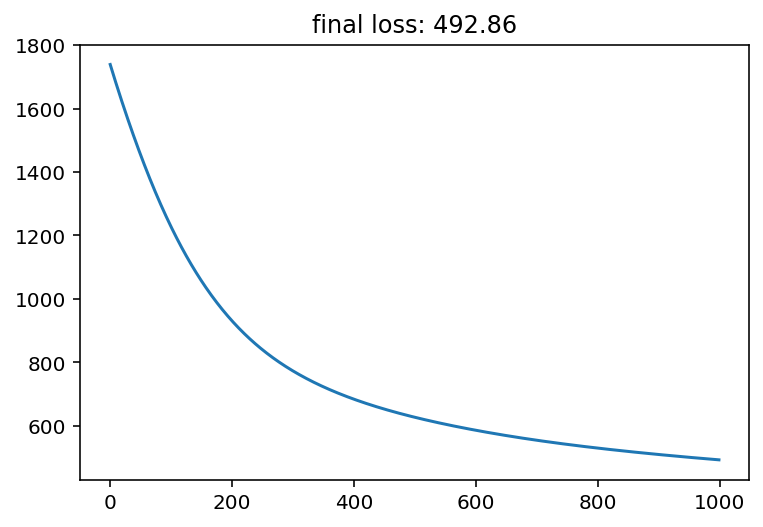

In [9]:
plt.plot(losses)
plt.title(f"final loss: {losses[-1]:.2f}")
plt.show()

We can use a confusion matrix to see how "confused" a model was. Read more on [Wikipedia](https://en.wikipedia.org/wiki/Confusion_matrix).

In [10]:
from sklearn.metrics import confusion_matrix

y_pred = nn_model(params, X.values)
confusion_matrix(y.values, np.round((y_pred)))

array([[583, 116],
       [ 95, 261]])

Text(33.0, 0.5, 'actual')

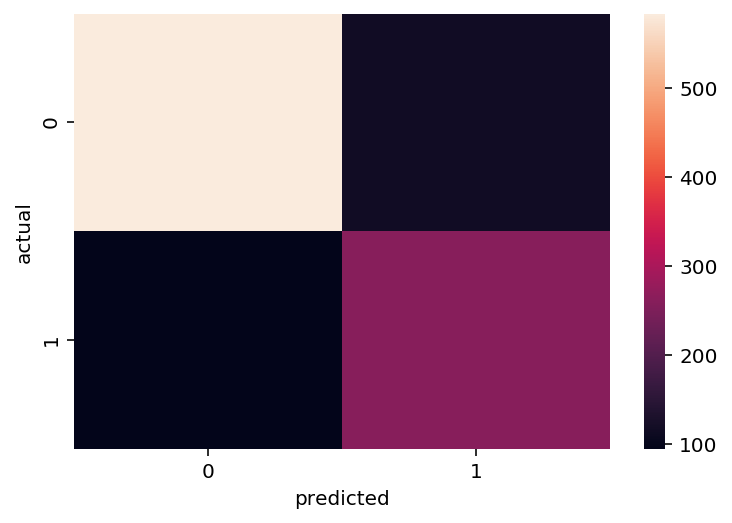

In [11]:
import seaborn as sns

sns.heatmap(confusion_matrix(y, np.round(y_pred)))
plt.xlabel('predicted')
plt.ylabel('actual')

# Recap

Deep learning, and more generally any modelling, has the following ingredients:

1. A model and its associated parameters to be optimized.
2. A loss function against which we are optimizing parameters.
3. An optimization routine.

You have seen these three ingredients at play with 3 different models: a linear regression model, a logistic regression model, and a deep feed forward neural network model.

## In Pictures

![](../figures/infographic.png) 

## Caveats of this tutorial

Deep learning is an active field of research. I have only shown you the basics here. In addition, I have also intentionally omitted certain aspects of machine learning practice, such as 

- splitting our data into training and testing sets, 
- performing model selection using cross-validation
- tuning hyperparameters, such as trying out optimizers
- regularizing the model, using L1/L2 regularization or dropout
- etc.

# Parting Thoughts

Deep learning is nothing more than optimization of a model with a really large number of parameters.

In its current state, it is not artificial intelligence. You should not be afraid of it; it is just a really powerful model that maps X to Y.

---

Now that you've finished learning what the foundational components of a deep learning are,
come check out the next notebook to learn
how deep learning framework developers organize these pieces
into useful tools that you can use.